In [21]:
import pandas as pd
import yfinance as yf
import bokeh
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [22]:
tickers_list = ['AAPL', 'WMT', 'IBM', 'HDO', 'BA', 'AXP']

df_prices = pd.DataFrame()

for ticker in tickers_list:
    prices = yf.download(ticker)['Adj Close']
    df_prices[ticker] = prices

df_prices.head()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,AAPL,WMT,IBM,HDO,BA,AXP
Date,,,,,,
1980-12-12,0.408971,0.124161,1.940252,NaN,1.691923,0.942247
1980-12-15,0.387633,0.123555,1.903365,NaN,1.703356,0.972318
1980-12-16,0.359183,0.121133,1.955007,NaN,1.697639,1.002390
1980-12-17,0.368074,0.120527,1.925496,NaN,1.754799,1.042485
1980-12-18,0.378743,0.122344,1.877543,NaN,1.760515,1.035803


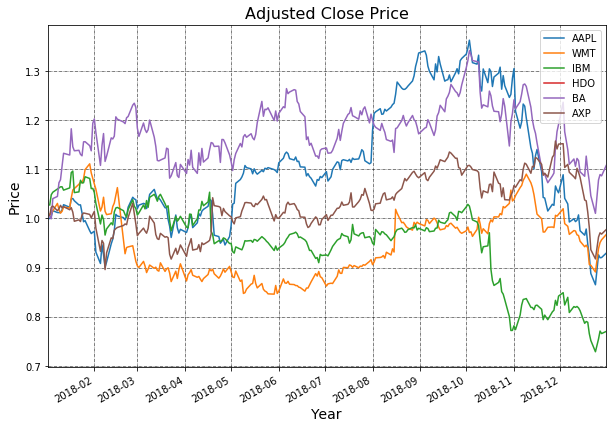

In [23]:
# Plot all the close prices
def plot_pegged_prices(df, start_date, end_date):    
#    start = '2018-01-01'
#    end = '2019-01-01'
    ((df.loc[start_date:end_date].pct_change()+1).cumprod()).plot(figsize=(10, 7))
    # Show the legend
    plt.legend()
    # Define the label for the title of the figure
    plt.title('Adjusted Close Price', fontsize=16)
    # Define the labels for x-axis and y-axis
    plt.ylabel('Price', fontsize=14)
    plt.xlabel('Year', fontsize=14)
    # Plot the grid lines
    plt.grid(which='major', color='k', linestyle='-.', linewidth=0.5)
    plt.show()    

plot_pegged_prices(df_prices, '2018-01-01', '2019-01-01')

In [4]:
def generate_recs_table(tickers_list, start_date, end_date):

    df_rec = pd.DataFrame({
        'Recommendation': ['Buy', 'Equal-Weight', 'Hold', 'Market Perform', 'Neutral',
                           'Outperform', 'Overweight', 'Sector Perform', 'Sell',
                           'Strong Buy', 'Underperform', 'Underweight']
        }
        )

    for ticker in tickers_list:
        try:
            df_temp = yf.Ticker(ticker).recommendations.loc[start_date:end_date].groupby('To Grade').count()['Firm'].reset_index()
            df_temp.columns = ['Recommendation',ticker]
            df_temp = df_temp[df_temp['Recommendation'] != '']
            df_rec = df_rec.merge(df_temp, how = 'left', on = 'Recommendation')
        except:
            continue
    return df_rec
        
generate_recs_table(tickers_list, '2017-06-01', '2019-07-01')

,Recommendation,AAPL,WMT,IBM,BA,AXP
0,Buy,44.0,13.0,2.0,1.0,8.0
1,Equal-Weight,6.0,4.0,NaN,1.0,10.0
2,Hold,7.0,2.0,1.0,2.0,NaN
3,Market Perform,9.0,3.0,2.0,NaN,2.0
4,Neutral,18.0,12.0,2.0,2.0,7.0
5,Outperform,12.0,5.0,3.0,1.0,1.0
6,Overweight,21.0,10.0,NaN,2.0,3.0
7,Sector Perform,NaN,1.0,NaN,NaN,NaN
8,Sell,NaN,NaN,NaN,NaN,NaN
9,Strong Buy,1.0,NaN,NaN,NaN,NaN


In [24]:
#Set up buy-hold-sell mapping and flag mapping
mapper = {
    'Buy': 'Buy',
    'Equal-Weight': 'Hold', 
    'Hold': 'Hold', 
    'Market Perform': 'Hold', 
    'Neutral': 'Hold',
    'Outperform': 'Buy', 
    'Overweight': 'Buy', 
    'Sector Perform': 'Hold', 
    'Sell': 'Sell',
    'Strong Buy': 'Buy', 
    'Underperform': 'Sell', 
    'Underweight': 'Sell'
    
}

buymap = {'Buy': 1,
         'Hold': 0,
         'Sell': 0
         }

holdmap = {'Buy': 0,
         'Hold': 1,
         'Sell': 0
         }

sellmap = {'Buy': 0,
         'Hold': 0,
         'Sell': 1
         }

In [25]:
#aggregate total buy/hold/sell recommendations by date for each stock in ticker list for visualization
def generate_recs_series(tickers_list, start_date, end_date):

    df_all = pd.DataFrame()

    tickers_list = ['AAPL', 'WMT', 'IBM', 'HDO', 'BA', 'AXP']

    for ticker in tickers_list:
        try:
            df_temp = yf.Ticker(ticker).recommendations.loc[start_date:end_date].reset_index()

            df_temp['Mapped Rec'] = df_temp['To Grade'].map(mapper)

            df_temp[ticker + ' Buy'] = df_temp['Mapped Rec'].map(buymap)
            df_temp[ticker + ' Hold'] = df_temp['Mapped Rec'].map(holdmap)
            df_temp[ticker + ' Sell'] = df_temp['Mapped Rec'].map(sellmap)
            df_temp = df_temp[['Date', ticker + ' Buy', ticker + ' Hold', ticker + ' Sell']]
            df_grouped = df_temp.groupby('Date').sum().reset_index()

            if len(df_all) == 0:
                df_all = df_grouped
            else:
                df_all = df_all.merge(df_grouped, how = 'outer', on = 'Date')
        except:
            continue

    return df_all

df = generate_recs_series(tickers_list, '2017-01-01', '2019-01-01')
print(df)

          Date  AAPL Buy  AAPL Hold  AAPL Sell  WMT Buy  WMT Hold  WMT Sell  \
0   2017-01-04       1.0        0.0        0.0      NaN       NaN       NaN   
1   2017-01-19       0.0        0.0        0.0      NaN       NaN       NaN   
2   2017-01-24       0.0        1.0        0.0      NaN       NaN       NaN   
3   2017-03-01       1.0        0.0        0.0      NaN       NaN       NaN   
4   2017-03-06       1.0        0.0        0.0      NaN       NaN       NaN   
5   2017-03-21       1.0        0.0        0.0      NaN       NaN       NaN   
6   2017-03-24       2.0        0.0        0.0      NaN       NaN       NaN   
7   2017-04-04       1.0        0.0        0.0      NaN       NaN       NaN   
8   2017-04-18       1.0        0.0        0.0      NaN       NaN       NaN   
9   2017-04-19       1.0        0.0        0.0      NaN       NaN       NaN   
10  2017-06-05       0.0        0.0        0.0      NaN       NaN       NaN   
11  2017-06-12       0.0        1.0        0.0      

In [33]:
from ipywidgets import interact
import numpy as np
from bokeh.io import push_notebook, show, output_notebook
from bokeh.plotting import figure
output_notebook()

Loading BokehJS ...

In [34]:
x = df['Date']
y = df['AAPL Buy']
p = figure(title='Recommendations', plot_height= 300, plot_width= 600, y_range= (0, 10), x_axis_type= 'datetime')
r = p.line(x, y, color='darkcyan', line_width= 3)

In [35]:
def update(f):
    r.data_source.data['y'] = df[f]
    push_notebook()

In [36]:
cols = []
for col in df.columns:
    if str(col) == 'Date':
        pass
    else:
        cols.append(str(col))

In [37]:
show(p, notebook_handle = True)


In [38]:
interact(update, f=cols)

<function __main__.update(f)>